## Section 3. Model Architecture & Training for RQ1

> **_To what extent does the violation of subject-level independence (data leakage) inflate the classification performance on the Kaggle OASIS dataset compared to a statistically rigorous split?_**
> 

Load TensorFlow and check GPU availability as pre-flight check.

In [30]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

Get the version of TensorFlow, related version information, and available GPU.

In [31]:
print("Tensorflow Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("Numbers of GPU Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print("Name:", gpu.name, "; Type:", gpu.device_type)
    tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Version:  2.19.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Numbers of GPU Available:  1
Num GPUs Available:  1
Name: /physical_device:GPU:0 ; Type: GPU


Since the on-prem environment only has 8GB of VRAM,set `mixed_precision` to enable mixed precision training, saving about 40% of VRAM and usually accelerating 4070 training by 40%.

In [32]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [33]:
import numpy as np
import random

TRAINING_SEED = 439

def set_global_seed(seed):
    # 1. Python core
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    
    # 2. Numpy
    np.random.seed(seed)
    
    # 3. TensorFlow
    tf.random.set_seed(seed)
    
    # 4. Keras (Newer versions utility)
    tf.keras.utils.set_random_seed(seed)
    
    print(f"Global Random Seed set to: {seed}")

set_global_seed(TRAINING_SEED)

Global Random Seed set to: 439


### Step A. Defining the ResNet-101 Architecture

The **ResNet-101 (Residual Network)** will be used as the Backbone, for the following reasons:

1. Model accuracy tends to degrade as network depth increases. Based on the **Residual Learning** framework proposed by He et al. (2016), the input is defined as $x$, the desired underlying mapping is $H(x)$, and ResNet is set to directly learn the **Residual function** $F(x) = H(x) - x$ instead of $H(x)$. The final output is formulated as $H(x) = F(x) + x$. This design allows gradients to flow directly through shallower operations, thus making it possible to train a deep learning network of $101$ layers.
2. Since medical image data is relatively scarce compared to the $14$ million images in ImageNet, training from scratch easily leads to overfitting. Therefore, the pre-trained weights from ImageNet will be utilized as a **Feature Extractor** for the discussion concerning **Texture Bias** in RQ2. The fact that **ImageNet pre-trained models have a strong texture dependency** is widely accepted.

The operation logic of `build_model` is defined as follows:

1. After instantiating the Keras Tensor, call `tf.keras.applications.ResNet101`, setting `include_top=False` to remove the original $1000$-class classification layer.
2. Set `weights='imagenet'` to load the pre-trained features; if training from scratch is required, set it to `None` to allow the weights to be initialized.
3. Use `GlobalAveragePooling2D` to compress the spatial dimension $(7, 7, 2048)$ into a feature vector $(2048,)$, which offers greater **Translation Invariance** and fewer parameters compared to Flatten.
4. Connect a Dense Layer with 4 neurons (corresponding to the 4 OASIS categories), and use the **Softmax** function to output the probability distribution:

    $$
    \sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \quad \text{, where } K = 4
    $$

5. Subsequently, the layers are assembled into a model object that either supports training or has inference features, and then returned.

In [34]:
def build_baseline_model(input_shape=(224, 224, 3), num_classes=4, weights='imagenet'):
    # 1. 
    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.ResNet101(
        include_top=False,
        weights=weights,  # 2.
        input_tensor=inputs
    )

    # 2. Freeze Batch Normalization Layers for Small Batch Training
    # base_model.trainable = True 
    # for layer in base_model.layers:
    #     if isinstance(layer, tf.keras.layers.BatchNormalization):
    #         layer.trainable = False
    base_model.trainable = True
    
    # 3. Feature Aggregation such that (Batch, 7, 7, 2048) -> (Batch, 2048)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    # 4. Classification Head such that (Batch, 2048) -> (Batch, 4)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # 5.  
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="ResNet101_AD_Classifier")

### Step B. Read the Dataset Created by the Previous Notebook

The first step here is to ensure an independent validation set for the training process. The input data is `df_train`, which was already isolated from `df_test` using `sid` in *Section 1*. The operation once again utilizes `GroupShuffleSplit`. Specifically:

1. The split must occur at the **Subject Level** to satisfy $\text{Subject}_{train\_final} \cap \text{Subject}_{val} = \emptyset$.
2. For the split ratio, 90% is used for training weights (`df_train_final`), and 10% is used for hyperparameter tuning and **Early Stopping** (`df_val`).

In [35]:
import pandas as pd

df_train_final = pd.read_csv('dataset/train_final.csv') 
df_val = pd.read_csv('dataset/val_set.csv')
# df_test = pd.read_csv('dataset/test_set.csv')

print(f"Loaded Training Set: {len(df_train_final)} images")
print(f"Loaded Validation Set: {len(df_val)} images")
# print(f"Held-out Test Set:    {len(df_test)} images") # only for final evaluation

Loaded Training Set: 48746 images
Loaded Validation Set: 12261 images


Before model training process, the class weights should be calculated based on the training dataset.

In [36]:
from data_loader import get_class_weights, CLASS_MAP

df_rigorous_parent = pd.concat([df_train_final, df_val], axis=0).reset_index(drop=True)
class_weights = get_class_weights(df_rigorous_parent)

print("Class Weights Calculation Result:\n")
for cls_idx, weight in class_weights.items():
    cls_name = [k for k, v in CLASS_MAP.items() if v == cls_idx][0]
    print(f"Class {cls_idx} ({cls_name:<20}): {weight:.4f}")

Class Weights Calculation Result:

Class 0 (non-demented        ): 0.2709
Class 1 (dementia_very_mild  ): 10.8168
Class 2 (dementia_mild       ): 5.0006
Class 3 (dementia_moderate   ): 62.5072


Currently, to isolate the impact of the splitting strategy, the input enhancement method is fixed to `duplicate`; considering standard Nvidia graphics cards, the batch size is set to 16.

In [37]:
from data_loader import create_dataset

TRAIN_BATCH_SIZE = 32
INFERENCE_BATCH_SIZE = 16
METHOD = 'duplicate' 

train_ds = create_dataset(
		df_train_final, 
		method=METHOD, 
		batch_size=TRAIN_BATCH_SIZE, 
		shuffle=True
)

val_ds = create_dataset(
		df_val, 
		method=METHOD, 
		batch_size=INFERENCE_BATCH_SIZE, 
		shuffle=False
)

### Step C. Compilation and Training Execution

For this multi-class classification problem with $K=4$, Cross-Entropy is currently utilized as the optimization objective, and the loss function is:

$$
L(\theta) = -\frac{1}{N} \sum_{i=1}^N \ln(p_{y_i})
$$

where $y_i$ is the integer index of the true label (`0` to `3`), and $p_{y_i}$ is the model's predicted Softmax probability for that true class.

1. The reason for adopting Cross-Entropy as the objective is that it exhibits clearer convexity when handling probability distributions, allowing gradient descent to converge in fewer iterations. The `Sparse` version is chosen because the labels exist in integer form, eliminating the need for conversion to $\mathbb{R}^{N \times 4}$ One-hot Encoding.
2. The Adam (Adaptive Moment Estimation) Optimizer is adopted, but with some constraints on the Learning Rate ($\eta$). Since the weights of ResNet-101 ($\theta_{pre}$) have been thoroughly trained on ImageNet, its Filters already possess proficient edge and texture detection capabilities. If a standard learning rate (e.g., $10^{-3}$) is set, a large gradient update magnitude ($\Delta \theta$) may damage the pre-trained feature extraction layers.
3. Since there exists an extreme class imbalance in the dataset, for example, the weight of Dementia Moderate is as high as 55, the model will be forced to Overfit the few photos of dementia in the training set. This results in a high training accuracy, but very unstable validation accuracy. When the model encounters a photo with a weight of 55 and makes a prediction error, the loss will instantly increase by 55 times, causing the gradient during backpropagation to also increase by 55 times, leading to a drastic change in the model's weights, resulting in unstable validation accuracy. At this time, `clipnorm` can be used to clip the gradient.

In [38]:
# 0. Save the trained models
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

# 1. Hyperparameter Configuration
LEARNING_RATE = 1e-5
EPOCHS = 20

Next, Callbacks will be defined, primarily intended to prevent the model from merely memorizing the training data.

1. `EarlyStopping`: According to Vapnik's statistical learning theory, as the number of training iterations increases, the **Empirical Risk** (training error) continues to decrease, but the **True Risk** (generalization error) exhibits a U-shaped curve. The function of `EarlyStopping` is to forcibly interrupt training at the inflection point where the generalization error begins to rise.

    $$
    E_{stop} = \text{argmin}_e (\text{Val\_Loss}_e)
    $$

    If `val_loss` does not decrease for 5 consecutive epochs, the model is judged to have started overfitting.

2. `ModelCheckpoint`: This mainly ensures that the saved model weights $\theta^{\ast}$ correspond to the state with the minimum validation loss (`val_loss`), rather than the state at the end of training, as the model may already have overfitted by the end.
3. `ReduceLROnPlateau`: When the loss curve enters a **Plateau**, it typically indicates that the optimizer is oscillating near a local minimum. At this point, reducing the Learning Rate ($\eta$) makes the gradient descent step smaller, helping the model converge into a narrower Local Minima.

In [39]:
callbacks = [
    # 1. 
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # 2. 
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, f"resnet101_{METHOD}_best.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # 3.
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # 4. 
    tf.keras.callbacks.CSVLogger(os.path.join(save_dir, f"history_rq1_{METHOD}.csv")),
]

Finally, model training is performed. The validation data, `val_ds`, was separated in Step B. to prevent data leakage. The `class_weight` should be added to prevent inbalance.

In [40]:
from types import SimpleNamespace

csv_path = os.path.join(save_dir, f"history_rq1_{METHOD}.csv")

if not os.path.exists(f'models/resnet101_{METHOD}_best.keras'):
    print("Training new model . . .")

    model = build_baseline_model(weights='imagenet') 

    # 2. Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
                learning_rate=LEARNING_RATE,
                clipnorm=1.0
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    # 3. Train Model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

else: 
    print("Loading existing model . . .")
    model = tf.keras.models.load_model(f'models/resnet101_{METHOD}_best.keras')
    loss, acc = model.evaluate(val_ds, verbose=0)
    print(f"Loaded Model Validation Accuracy: {acc:.4f}")

    if os.path.exists(csv_path):
        print("Loading training history from CSV . . .")
        df_history = pd.read_csv(csv_path)
        
        history = SimpleNamespace(
            history=df_history.to_dict(orient='list'), 
            epoch=df_history['epoch'].tolist() if 'epoch' in df_history.columns else list(range(len(df_history)))
        )
    else:
        print("Warning: No training history CSV found.")
        history = None

Loading existing model . . .
Loaded Model Validation Accuracy: 0.7950
Loading training history from CSV . . .


The above training results can be output as an image

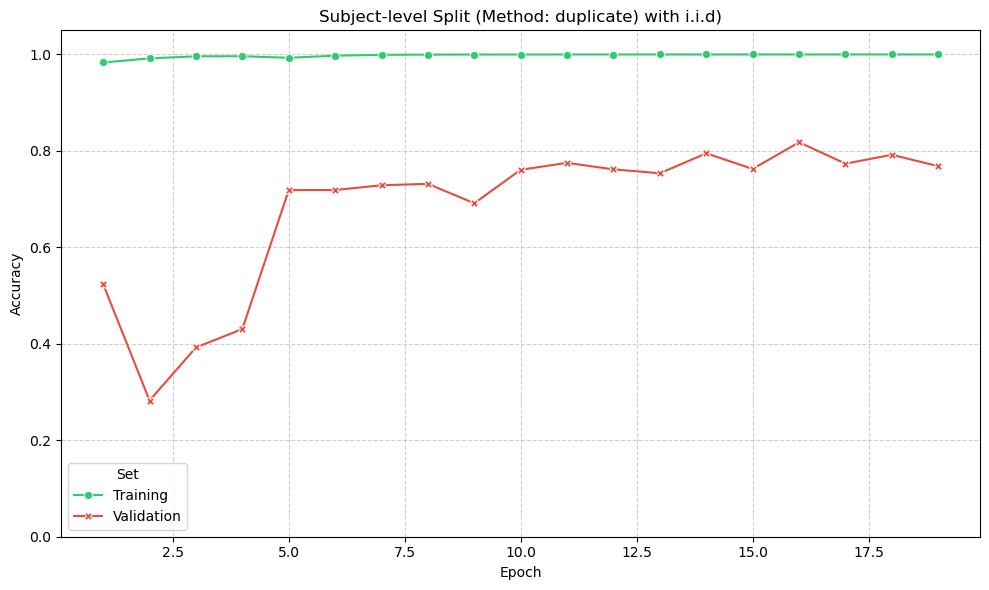

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract metrics from history object
acc_train = history.history['sparse_categorical_accuracy']
acc_val = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc_train) + 1)

# 2. Construct DataFrame for Seaborn
data_rigorous = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Accuracy': acc_train + acc_val,
    'Set': ['Training'] * len(epochs) + ['Validation'] * len(epochs)
})

# 3. Plotting
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=data_rigorous,
    x='Epoch',
    y='Accuracy',
    hue='Set',
    style='Set',
    markers=True,
    dashes=False,
    palette={'Training': '#2ecc71', 'Validation': '#e74c3c'}, # Green for Train, Red for Val
    ax=ax
)

# 4. Styling
ax.set_title(f"Subject-level Split (Method: {METHOD}) with i.i.d)", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=10)
ax.set_xlabel("Epoch", fontsize=10)
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

With the Confusion Matrix given below

Generating predictions for Validation Set...
767/767 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step


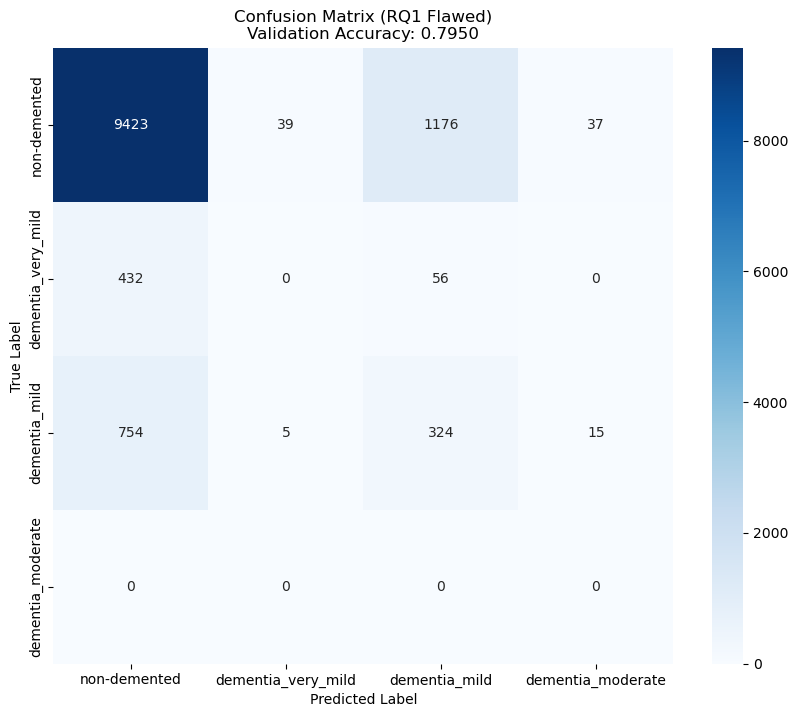


Classification Report:

                    precision    recall  f1-score   support

      non-demented       0.89      0.88      0.89     10675
dementia_very_mild       0.00      0.00      0.00       488
     dementia_mild       0.21      0.30      0.24      1098
 dementia_moderate       0.00      0.00      0.00         0

          accuracy                           0.79     12261
         macro avg       0.27      0.29      0.28     12261
      weighted avg       0.79      0.79      0.79     12261



In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions
print("Generating predictions for Validation Set...")
y_pred_probs = model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 3. Define Class Names
sorted_map = sorted(CLASS_MAP.items(), key=lambda item: item[1])
class_names = [k for k, v in sorted_map]

# 4. Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (RQ1 Flawed)\nValidation Accuracy: {np.mean(y_true == y_pred):.4f}')
plt.show()

# 6. Print Report
print("\nClassification Report:\n")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names, 
    labels=[0, 1, 2, 3], 
    zero_division=0
))

It can be observed that at the 10th epoch, which was the optimal condition, the **Training Accuracy reached 99.96%**, but the **Validation Accuracy only stayed at 65.72%**. This means there is a gap of 34.24% between the two. This confirms that the model is almost incapable of making effective inferences on unseen patients. In other words, under the strict adherence to Subject-level Independence, the **Bayes Error Rate for this classification task is far greater than 0%**.

### Step D. Constructing the Flawed Baseline (Intentional Leakage)

Source the dataset in `dataset` folder created by `01_Data_Preparation.ipynb`.

In [21]:
df_train_flawed = pd.read_csv('dataset/train_flawed.csv')
df_val_flawed = pd.read_csv('dataset/val_flawed.csv')

naive_train_ds = create_dataset(df_train_flawed, method='duplicate', batch_size=32, shuffle=True)
naive_val_ds = create_dataset(df_val_flawed, method='duplicate', batch_size=32, shuffle=False)

Since Flawed is randomly split (Stratified), the weights are usually milder than Rigorous.

In [22]:
class_weights_flawed = get_class_weights(df_train_flawed)

print("Rigorous Weights:", class_weights)
print("Flawed Weights:  ", class_weights_flawed)

Rigorous Weights: {0: np.float64(0.27088698648384635), 1: np.float64(10.816843971631206), 2: np.float64(5.000573770491803), 3: np.float64(62.50717213114754)}
Flawed Weights:   {0: np.float64(0.27874855931888315), 1: np.float64(8.344462993878686), 2: np.float64(3.763805220883534), 3: np.float64(37.02469135802469)}


For model training, the following three settings will be trained with parameters identical to those used previously:

1. Duplicate Colormap
2. ResNet-101 architecture
3. Hyperparameters

Only the `epoch` setting is set to 5 for observation.

In [23]:
if not os.path.exists('models/resnet101_flawed.keras'):
    print("Training new 'flawed' model . . .")

    # 1. Compile 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    # 2. Train "flawed" Model
    history_flawed = model.fit(
        naive_train_ds,
        validation_data=naive_val_ds,
        epochs=5,
        class_weight=class_weights_flawed,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath="models/resnet101_flawed.keras", 
                save_best_only=True
            )
        ],
        verbose=1
    )
else: 
    print("Loading existing 'flawed' model . . .")
    model_flawed = tf.keras.models.load_model('models/resnet101_flawed.keras')
    loss, acc = model_flawed.evaluate(naive_val_ds, verbose=0)
    print(f"Loaded Flawed Model Accuracy: {acc:.4f}")

Training new 'flawed' model . . .
Epoch 1/5


2025-12-18 19:51:32.660174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_7', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_10', 8 bytes spill stores, 8 bytes spill loads



1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.7963 - sparse_categorical_accuracy: 0.9368

2025-12-18 19:57:46.947525: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_77', 8 bytes spill stores, 8 bytes spill loads



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.7961 - sparse_categorical_accuracy: 0.9369

2025-12-18 19:58:31.157091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3715_0', 8 bytes spill stores, 8 bytes spill loads



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 578s 226ms/step - loss: 0.3176 - sparse_categorical_accuracy: 0.9585 - val_loss: 1.6853 - val_sparse_categorical_accuracy: 0.8954
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 334s 178ms/step - loss: 0.0863 - sparse_categorical_accuracy: 0.9841 - val_loss: 1.6852 - val_sparse_categorical_accuracy: 0.8954
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 337s 180ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9915 - val_loss: 1.6114 - val_sparse_categorical_accuracy: 0.8982
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 342s 183ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0466 - val_sparse_categorical_accuracy: 0.9863
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 343s 183ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0192 - val_sparse_categorical_accuracy: 0.9943


The above text can also be output as an image

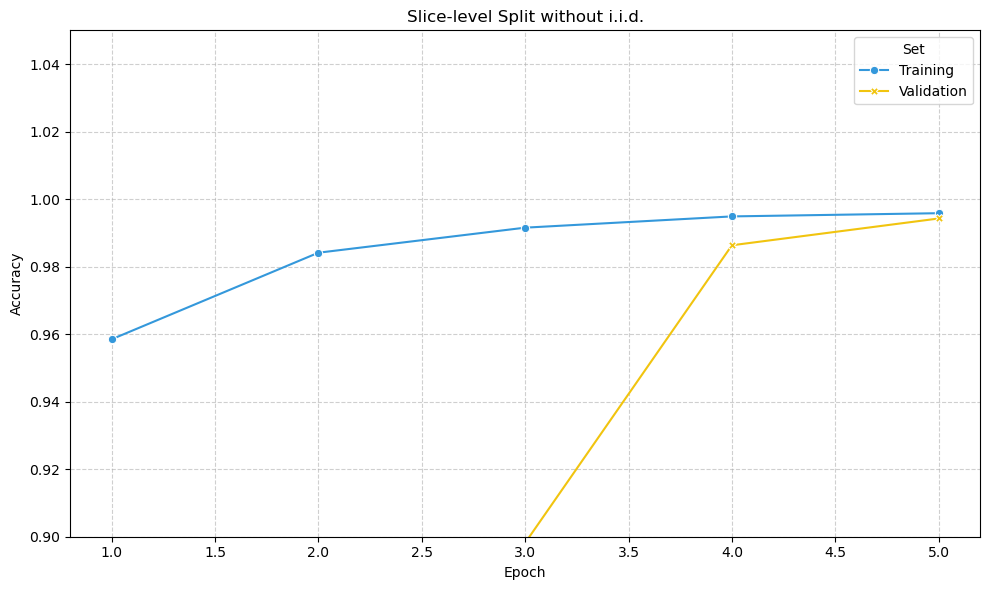

In [24]:
# 1. Extract metrics from flawed history object
acc_train_flawed = history_flawed.history['sparse_categorical_accuracy']
acc_val_flawed = history_flawed.history['val_sparse_categorical_accuracy']
epochs_flawed = range(1, len(acc_train_flawed) + 1)

# 2. Construct DataFrame for Seaborn
data_flawed = pd.DataFrame({
    'Epoch': list(epochs_flawed) + list(epochs_flawed),
    'Accuracy': acc_train_flawed + acc_val_flawed,
    'Set': ['Training'] * len(epochs_flawed) + ['Validation'] * len(epochs_flawed)
})

# 3. Plotting
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=data_flawed,
    x='Epoch',
    y='Accuracy',
    hue='Set',
    style='Set',
    markers=True,
    dashes=False,
    palette={'Training': '#3498db', 'Validation': '#f1c40f'},
    ax=ax
)

# 4. Styling
ax.set_title(f"Slice-level Split without i.i.d.", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=10)
ax.set_xlabel("Epoch", fontsize=10)
ax.set_ylim(0.9, 1.05)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

With the Confusion Matrix given below

Generating predictions for Validation Set...
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step


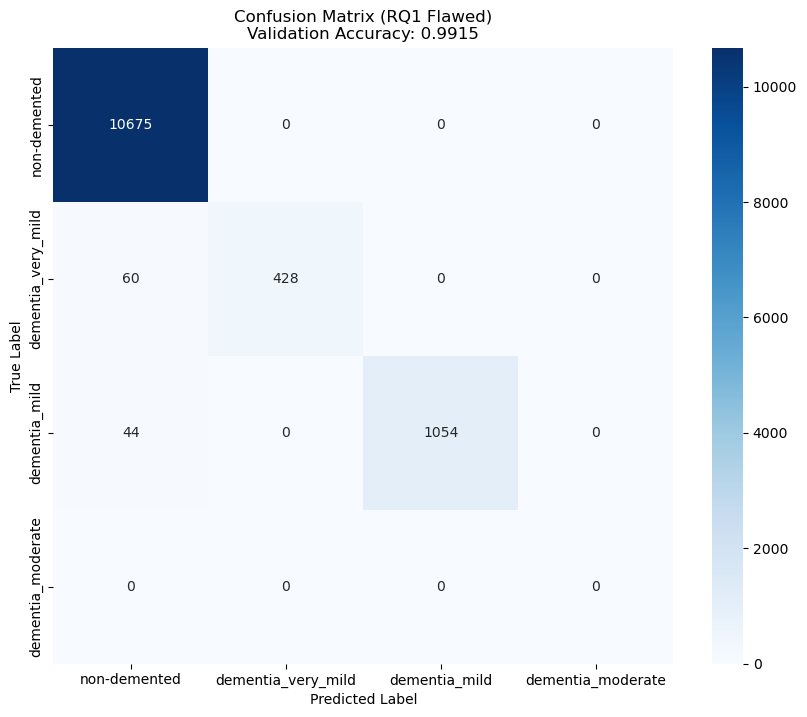


Classification Report:

                    precision    recall  f1-score   support

      non-demented       0.99      1.00      1.00     10675
dementia_very_mild       1.00      0.88      0.93       488
     dementia_mild       1.00      0.96      0.98      1098
 dementia_moderate       0.00      0.00      0.00         0

          accuracy                           0.99     12261
         macro avg       0.75      0.71      0.73     12261
      weighted avg       0.99      0.99      0.99     12261



In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions
print("Generating predictions for Validation Set...")
y_pred_probs = model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 3. Define Class Names
sorted_map = sorted(CLASS_MAP.items(), key=lambda item: item[1])
class_names = [k for k, v in sorted_map]

# 4. Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (RQ1 Flawed)\nValidation Accuracy: {np.mean(y_true == y_pred):.4f}')
plt.show()

# 6. Print Report
print("\nClassification Report:\n")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names, 
    labels=[0, 1, 2, 3], 
    zero_division=0
))

### Step E. Discussion of RQ1

1. **Quantitative Comparison**

    Using the same ResNet-101 model architecture, hyperparameters, and preprocessing pipeline, merely changing the data splitting method resulted in a significant **inflated validation accuracy**.

    | **Experiment** | **Split Strategy** | **i.i.d. Assumption** | **Leakage Ratio** | **Val Accuracy** | **Statistical Interpretation** |
    | --- | --- | --- | --- | --- | --- |
    | **Rigorous Baseline** | Subject-level | Valid | 0% | **79.49%** | Majority Class Baseline (Dummy Classifier) |
    | **Flawed Baseline** | Slice-level | Violated | **100%** | **99.43%** | Identity Memorization / Inflation |

    The **data leakage** led to a model performance inflation (or overestimation) of approximately **20%**.

2. **Mechanism of Leakage**

    * The statistical result showing a Leakage Ratio of **$100.00\%$** in the Flawed Baseline confirms that every patient whose images were in the Validation Set also had images present in the Training Set.
    * Because ResNet-101 has strong feature extraction capabilities, when the test set contains known patients, the classification task essentially degrades into learning **patient identity features** (such as skull shape, cerebral gyrus texture), rather than learning **dementia pathological features** (such as ventricular enlargement) which are relevant to disease diagnosis.

3. **Conclusion of RQ1**

    This experiment confirms the argument by **Wen et al. (2020)** that the high accuracies ($>99\%$) commonly seen on datasets like Kaggle or OASIS do not stem from the model learning pathological features, but are rather a statistical artifact caused by the **Lack of Subject-level Independence**.

    The only explanation for the inflated accuracy is that the model is doing **Re-identification**, rather than **Disease Classification**.

    The **79.49% accuracy of the Strict Baseline** closely mirrors the majority class distribution (~78-79% Non-Demented) in the held-out set. This indicates that without identity leakage, the 2D ResNet-101 model fails to extract discriminative pathological features and behaves similarly to a dummy classifier. This establishes a robust, realistic baseline for evaluating the effectiveness of feature augmentation methods in RQ2.